## 1. Googlenet

#### 1.1. Import Libraries

In [82]:
import os
import gzip
import numpy as np
import urllib.request
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

In [83]:
# URLs for MNIST dataset files
urls = {
    "train_images": "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "test_images": "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels": "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
}

#### 1.2. Download and Extract data

Creates a directory named data. Calls the download_and_extract function for both training and test datasets to retrieve images and labels.
Reshapes the images into a format suitable for processing: each image is reshaped from a flat array to a 28x28 matrix and normalized to a range between 0 and 1 by dividing by 255.Combines the training and test datasets into single arrays for both images and labels, enabling easier handling during model training.


In [84]:
# Function to download and extract files
def download_and_extract(url, path, is_label=False):
    if not os.path.exists(path):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"{path} already exists, skipping download.")

    offset = 8 if is_label else 16  # Adjust for different header sizes
    with gzip.open(path, 'rb') as f:
        return np.frombuffer(f.read(), dtype=np.uint8)[offset:]

def load_mnist_data():
    os.makedirs('./data', exist_ok=True)

    # Download and extract the MNIST data
    train_images = download_and_extract(urls['train_images'], './data/train-images.gz')
    train_labels = download_and_extract(urls['train_labels'], './data/train-labels.gz', is_label=True)
    test_images = download_and_extract(urls['test_images'], './data/test-images.gz')
    test_labels = download_and_extract(urls['test_labels'], './data/test-labels.gz', is_label=True)

    # Reshape and normalize the images
    train_images = train_images.reshape(-1, 28, 28) / 255.0
    test_images = test_images.reshape(-1, 28, 28) / 255.0

    # Combine train and test datasets for custom split
    images = np.concatenate((train_images, test_images), axis=0)
    labels = np.concatenate((train_labels, test_labels), axis=0)
        
    return images, labels

#### 1.3. Split the dataset

In [85]:
# Load the MNIST data
images, labels = load_mnist_data()
print("MNIST data downloaded and loaded.")

# Split data into training, validation, and testing sets
def split_data(images, labels):
    total_size = len(images)

    # Sizes for each split
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    train_images, train_labels = images[:train_size], labels[:train_size]
    val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_data(images, labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")


./data/train-images.gz already exists, skipping download.
./data/train-labels.gz already exists, skipping download.
./data/test-images.gz already exists, skipping download.
./data/test-labels.gz already exists, skipping download.
MNIST data downloaded and loaded.
Training set size: 42000
Validation set size: 14000
Test set size: 14000


#### 1.4. Custom Dataset for MNIST

This section of the code defines a custom dataset class for the MNIST dataset, enabling the integration of MNIST images into PyTorch's DataLoader for model training and evaluation.

In [86]:
# Define the custom dataset for MNIST
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = np.stack([image] * 3, axis=-1)  # Convert to 3 channels for GoogLeNet

        # Convert the numpy array to a PIL Image
        image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

#### 1.5. Data Transformations and Data Loaders

In this section, I defined the transformations to be applied to the MNIST dataset images and set up DataLoaders for efficient data handling during model training and evaluation.

In [87]:
# Define transformations and data loaders with explicit float conversion
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize across 3 channels
])

# Use the updated transform in the Dataset class
train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
val_dataset = MNISTDataset(val_images, val_labels, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### 1.6. Load the Googlenet model


In [88]:
# Load GoogLeNet model and set the final layer for 10 classes 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 1.7. Train model

In [89]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

Epoch [1/20], Train Loss: 0.1648, Val Loss: 0.0496
Epoch [2/20], Train Loss: 0.0633, Val Loss: 0.0454
Epoch [3/20], Train Loss: 0.0510, Val Loss: 0.0382
Epoch [4/20], Train Loss: 0.0417, Val Loss: 0.0494
Epoch [5/20], Train Loss: 0.0384, Val Loss: 0.0390
Epoch [6/20], Train Loss: 0.0322, Val Loss: 0.0468
Epoch [7/20], Train Loss: 0.0299, Val Loss: 0.0312
Epoch [8/20], Train Loss: 0.0289, Val Loss: 0.0442
Epoch [9/20], Train Loss: 0.0257, Val Loss: 0.0430
Epoch [10/20], Train Loss: 0.0264, Val Loss: 0.0345
Epoch [11/20], Train Loss: 0.0227, Val Loss: 0.0613
Epoch [12/20], Train Loss: 0.0210, Val Loss: 0.0435
Epoch [13/20], Train Loss: 0.0206, Val Loss: 0.0395
Epoch [14/20], Train Loss: 0.0146, Val Loss: 0.0438
Epoch [15/20], Train Loss: 0.0206, Val Loss: 0.0343
Epoch [16/20], Train Loss: 0.0106, Val Loss: 0.0351
Epoch [17/20], Train Loss: 0.0104, Val Loss: 0.0304
Epoch [18/20], Train Loss: 0.0094, Val Loss: 0.0398
Epoch [19/20], Train Loss: 0.0122, Val Loss: 0.0373
Epoch [20/20], Train 

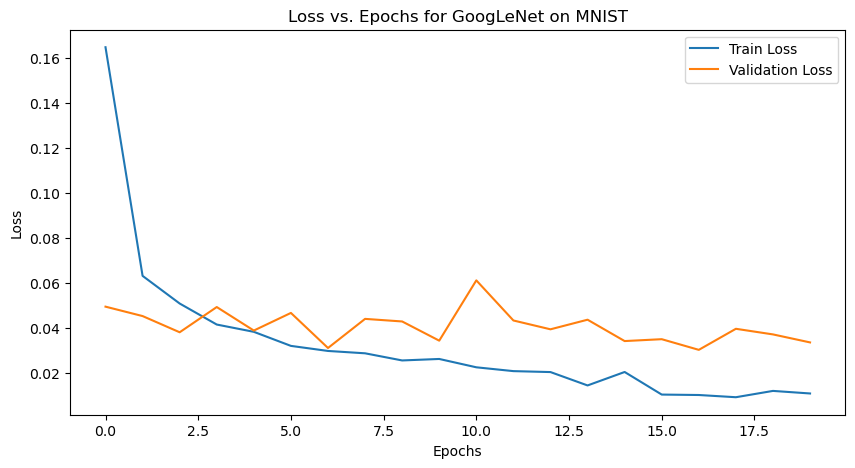

In [90]:
# Train the model and record losses
num_epochs = 20
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

# Plot the loss vs. epochs graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs for GoogLeNet on MNIST")
plt.show()
